# Find the best cross-validation run

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/fold_results.csv')

# Filter rows where 'Fold' is 'Average' and 'Final Model' is not 1
average_rows = df[(df['Fold'] == 'Average') & (df['Final Model'] != 1)]

best_f1_row = average_rows.loc[average_rows['F1'].idxmax()]
best_run_id = best_f1_row['Run ID']
print(best_f1_row)

print(best_run_id)

Fold                             Average
Run ID           20240630142148_f5a1fb5c
Final Model                          0.0
Best Loss                       0.330355
Loss                            0.330355
Accuracy                        0.892593
F1                              0.894518
Num Classes                          9.0
Input Size                          12.0
Hidden Size                        100.0
Num Layers                           2.0
Output Size                          1.0
Num Epochs                         400.0
Learning Rate                     0.0004
Batch Size                          32.0
Name: 600, dtype: object
20240630142148_f5a1fb5c


In [266]:
def get_hyperparameters_for_average_run(df, run_id):
    run_data = df[df['Run ID'] == run_id]

    if not run_data.empty:
        first_row = run_data.iloc[0]
        # Extract the hyperparameters
        hyperparameters = (
            first_row['Num Classes'],
            first_row['Input Size'],
            first_row['Hidden Size'],
            first_row['Num Layers'],
            first_row['Output Size'],
            first_row['Num Epochs'],
            first_row['Learning Rate'],
            first_row['Batch Size']
        )
        return hyperparameters
    else:
        return "Run ID not found."

In [267]:
ideal_hyperparameters = get_hyperparameters_for_average_run(df, best_run_id)
print(ideal_hyperparameters)

(9.0, 12.0, 100.0, 2.0, 1.0, 400.0, 0.0004, 32.0)


In [268]:
def find_runs_with_hyperparameters(df, hyperparameters):
    num_classes, input_size, hidden_size, num_layers, output_size, num_epochs, learning_rate, batch_size = hyperparameters
    
    # Filter the DataFrame for rows matching all specified hyperparameters
    matching_runs = df[
        (df['Num Classes'] == num_classes) &
        (df['Input Size'] == input_size) &
        (df['Hidden Size'] == hidden_size) &
        (df['Num Layers'] == num_layers) &
        (df['Output Size'] == output_size) &
        (df['Num Epochs'] == num_epochs) &
        (df['Learning Rate'] == learning_rate) &
        (df['Batch Size'] == batch_size)
    ]
    
    # Extract the 'Run ID' column from the filtered DataFrame and remove duplicates
    run_ids = tuple(matching_runs['Run ID'].unique())
    
    return run_ids


hyperparameters = (9, 12, 100, 2, 1, 600, 0.000179, 32)  # Replace this with the hyperparameters you're interested in
matching_run_ids = find_runs_with_hyperparameters(df, ideal_hyperparameters)
print(matching_run_ids)

('20240630141512_d6de5016', '20240630142148_f5a1fb5c', '20240630142812_46e94cff', '20240630150835_d537206d', '20240630151315_85f9020a', '20240630151756_199c1ba8', '20240630150836_832e82fb', '20240630151147_4db78d14', '20240630151445_8d2fcf2f', '20240630152236_f3409d27', '20240630152531_b366bfaf', '20240630152824_21b55519')


# Loss Graphing

## Fold Average Losses

In [269]:
sns.set_theme(style="whitegrid", palette="pastel")

The maximum Row Index value is: 399
The maximum Row Index value is: 399


/tmp/ipykernel_81613/746282140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()
/tmp/ipykernel_81613/746282140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()
/tmp/ipykernel_81613/746282140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

<Axes: title={'center': 'Final Model Cross-validation Mean Loss vs Epochs'}, xlabel='Epochs', ylabel='Mean Loss'>

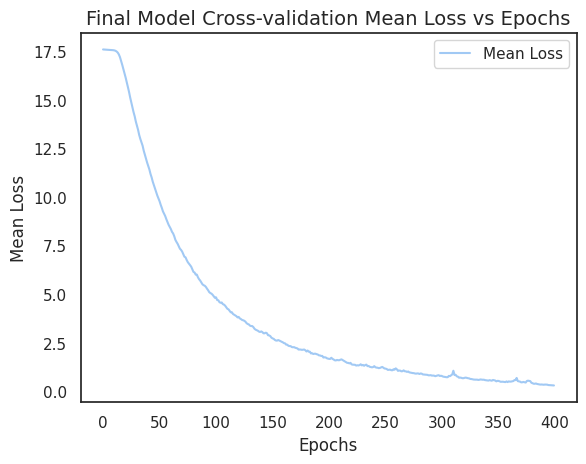

In [283]:
def get_mean_loss_stats_for_folds(run_ids):
    df = pd.read_csv("data/fold_detailed_losses.csv")
    aggregated_stats = pd.DataFrame()

    for run_id in run_ids:
        # Filter for entries with the correct 'Run ID' and not final models (Fold Index != 100)
        df_filtered = df[(df['Run ID'] == run_id) & (df['Fold Index'] != 100)]
        
        # If there are no entries after filtering, skip to the next iteration
        if df_filtered.empty:
            continue
        
        # Use groupby on 'Fold Index' and use cumcount to generate a new 'Row Index' that restarts for each fold
        df_filtered['Row Index'] = df_filtered.groupby('Fold Index').cumcount()

    # Reset index for the aggregated DataFrame
    df_filtered.reset_index(drop=True, inplace=True)
    
    return df_filtered

def calculate_mean_loss_by_index(df):
    mean_loss_by_index = df.groupby('Row Index')['Loss'].mean().reset_index()
    mean_loss_by_index.columns = ['Row Index', 'Mean Loss']
    
    return mean_loss_by_index

data = get_mean_loss_stats_for_folds(matching_run_ids)
max_row_index = data['Row Index'].max()
print(f"The maximum Row Index value is: {max_row_index}")

#print(data.head)
mean_loss_stuff = calculate_mean_loss_by_index(data)
max_row_index = mean_loss_stuff['Row Index'].max()
print(f"The maximum Row Index value is: {max_row_index}")
plt.xlabel('Epochs', fontsize=12)

plt.title('Final Model Cross-validation Mean Loss vs Epochs', fontsize=14)

#print(mean_loss_stuff.head)
sns.lineplot(x='Row Index', y='Mean Loss', data=mean_loss_stuff, label='Mean Loss')

## Final-Model Average Loss

In [281]:
def calculate_mean_and_std_loss_by_index(data):
    stats = data.groupby('Row Index').agg({
        'Loss': ['mean', 'std']
    }).reset_index()
    stats.columns = ['Row Index', 'Mean Loss', 'Std Loss']
    return stats


# Metrics Graphing

## Fold Metrics

    Fold                   Run ID  Accuracy        F1
579    0  20240630141512_d6de5016  0.888889  0.885949
580    1  20240630141512_d6de5016  0.814815  0.799626
581    2  20240630141512_d6de5016  0.851852  0.853947
582    3  20240630141512_d6de5016  0.740741  0.770106
583    4  20240630141512_d6de5016  0.851852  0.860045


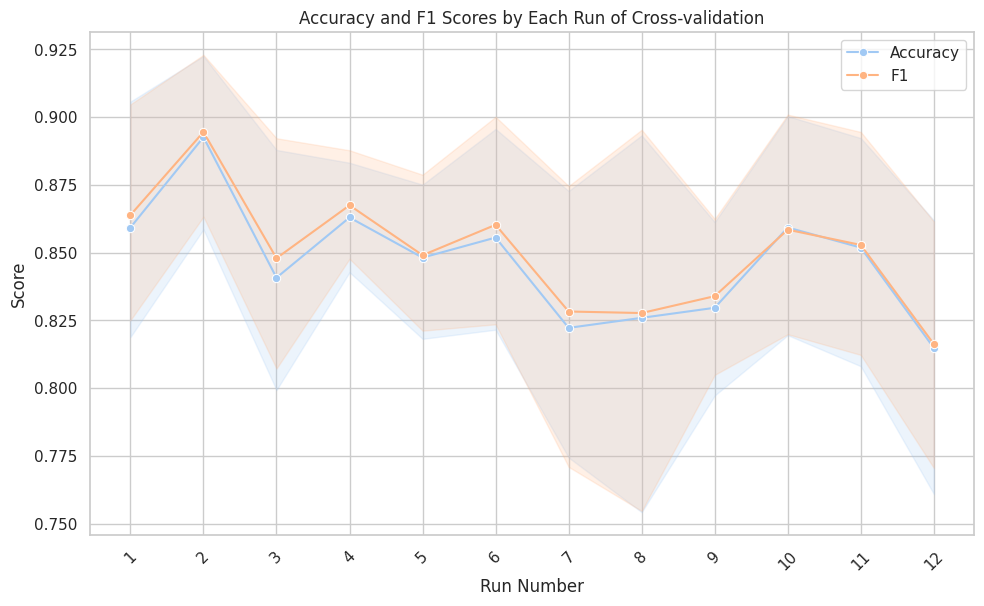

In [272]:
def get_folds_model(run_ids):
    df = pd.read_csv("data/fold_results.csv")  
    df_folds = df[df['Final Model'] != 1]
    df_filtered = df_folds[df_folds['Run ID'].isin(run_ids)]
    accuracy_data = df_filtered[['Fold', 'Run ID', 'Accuracy', 'F1']]
    
    return accuracy_data

# Example usage
accuracy_data = get_folds_model(matching_run_ids)
print(accuracy_data.head(5))

plt.figure(figsize=(10, 6))

# Create a mapping of Run IDs to sequential numbers
run_id_mapping = {run_id: i+1 for i, run_id in enumerate(accuracy_data['Run ID'].unique())}

# Create a new column with sequential numbers
accuracy_data['Run Number'] = accuracy_data['Run ID'].map(run_id_mapping)

# Create the line plots for Accuracy and F1 using the new Run Number
sns.lineplot(x='Run Number', y='Accuracy', data=accuracy_data, marker='o', label='Accuracy')
sns.lineplot(x='Run Number', y='F1', data=accuracy_data, marker='o', label='F1')

# Set x-ticks to be integers
plt.xticks(range(1, len(run_id_mapping) + 1))

# Improve the layout
plt.xticks(rotation=45)  # Rotate the x-axis labels to prevent overlap
plt.tight_layout()  # Adjust the layout to make room for the rotated labels

# Add labels and title
plt.xlabel('Run Number')
plt.ylabel('Score')
plt.title('Accuracy and F1 Scores by Each Run of Cross-validation')

# Save the plot to a file
plt.savefig('accuracy_f1_scores_folds.png')

# Show the plot
plt.show()


## Final Model Metrics

   Final Model Runs Fold                   Run ID  Accuracy        F1
0                 0    0  20240630142812_46e94cff  0.870270  0.871738
1                 1    0  20240630151756_199c1ba8  0.894595  0.897198
2                 2    0  20240630151756_199c1ba8  0.848649  0.849739
3                 3    0  20240630151756_199c1ba8  0.864865  0.867387
4                 4    0  20240630151756_199c1ba8  0.889189  0.891721
Average Weighted F1 Score: 0.8760


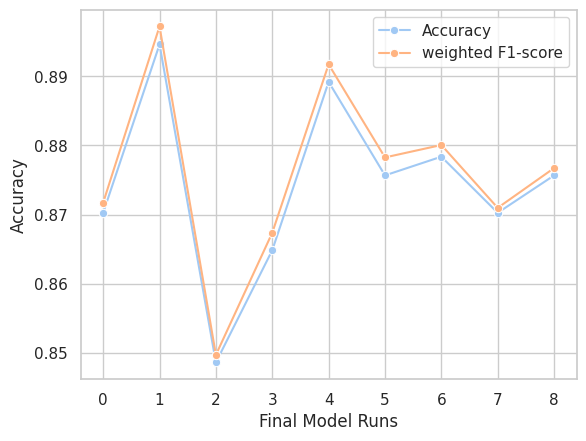

In [273]:
def get_metrics_final_model(run_ids):
    df = pd.read_csv("data/fold_results.csv")
    df_final_models = df[df['Final Model'] == 1]
    df_filtered = df_final_models[df_final_models['Run ID'].isin(run_ids)]
    accuracy_data = df_filtered[['Fold', 'Run ID', 'Accuracy', 'F1']]
    
    accuracy_data = accuracy_data.reset_index(drop=True).reset_index()
    accuracy_data = accuracy_data.rename(columns={'index': 'Final Model Runs'})
    
    return accuracy_data


accuracy_data = get_metrics_final_model(matching_run_ids)
print(accuracy_data.head(5))
sns.lineplot(x='Final Model Runs', y='Accuracy', data=accuracy_data, marker='o', label='Accuracy', errorbar='sd')
sns.lineplot(x='Final Model Runs', y='F1', data=accuracy_data, marker='o', label='weighted F1-score', errorbar='sd')

# Calculate and print the average F1 score
average_f1 = accuracy_data['F1'].mean()
print(f"Average Weighted F1 Score: {average_f1:.4f}")


# Hyperparameter Comparisons

In [274]:
# DO HYPER-PARAMETER COMPARISON

def metrics_vs_learning_rate():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_lr = df_average[['Learning Rate', 'F1', 'Accuracy']]
    
    return df_lr

def metrics_vs_hidden_size():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_hs = df_average[['Hidden Size', 'F1', 'Accuracy']]
    
    return df_hs

def metrics_vs_epochs():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_ep = df_average[['Num Epochs', 'F1', 'Accuracy']]
    
    return df_ep

def metrics_vs_batch_size():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_bs = df_average[['Batch Size', 'F1', 'Accuracy']]
    
    return df_bs

def make_graph(data, x, name):
    color_weighted_f1 = '#0072B2'  # Blue
    color_accuracy = '#D55E00'  # Red
        
    long_data = pd.melt(data, id_vars=[x], value_vars=['F1', 'Accuracy'], var_name='Metric', value_name='Value')
    long_data['Metric'] = long_data['Metric'].replace({'F1': 'Weighted F1'})
    
    sns.set_style("white")
    
    g = sns.JointGrid(data=long_data, x=x, y='Value', height=8, ratio=4)
    
    # Plot KDE and scatter in the joint area
    sns.kdeplot(data=long_data, x=x, y='Value', ax=g.ax_joint, zorder=0, levels=6, hue='Metric', 
                palette={'Weighted F1': color_weighted_f1, 'Accuracy': color_accuracy}, alpha=0.5)
    sns.scatterplot(data=long_data, x=x, y='Value', hue='Metric', ax=g.ax_joint, 
                    palette={'Weighted F1': color_weighted_f1, 'Accuracy': color_accuracy})
    
    # Plot KDE for 'Value' on the side
    for metric in long_data['Metric'].unique():
        subset = long_data[long_data['Metric'] == metric]
        sns.kdeplot(y=subset['Value'], ax=g.ax_marg_y, fill=True, alpha=0.5, 
                    color=color_weighted_f1 if metric == 'Weighted F1' else color_accuracy)
    
    # Plot KDE for 'x' on the top, adjusting bandwidth as needed
    for metric, color in zip(['Weighted F1', 'Accuracy'], [color_weighted_f1, color_accuracy]):
        subset = long_data[long_data['Metric'] == metric]
        sns.kdeplot(x=subset[x], ax=g.ax_marg_x, fill=True, alpha=0.5, color=color, bw_adjust=0.75)
    
    g.ax_joint.grid(False)
    sns.despine()
    g.ax_joint.legend(title='Metric', loc='lower right')
    plt.tight_layout()
    plt.savefig(name + '.png')

## Learning Rate per Folds

In [275]:
f1_tuning = metrics_vs_learning_rate()

print(f1_tuning.head(5))
#sns.lineplot(x='Learning Rate', y='F1', data=f1_tuning, marker='o', label='Mean Loss')

#sns.jointplot(x='Learning Rate', y='F1', data=f1_tuning, kind="kde", color="#4CB391")
#sns.jointplot(x='Learning Rate', y='Accuracy', data=f1_tuning, kind="kde", color="#4CB391")




    Learning Rate        F1  Accuracy
10       0.000179  0.881710  0.874074
22       0.000058  0.661093  0.670370
34       0.000200  0.839489  0.837037
46       0.000170  0.823380  0.829630
58       0.000165  0.842551  0.840741


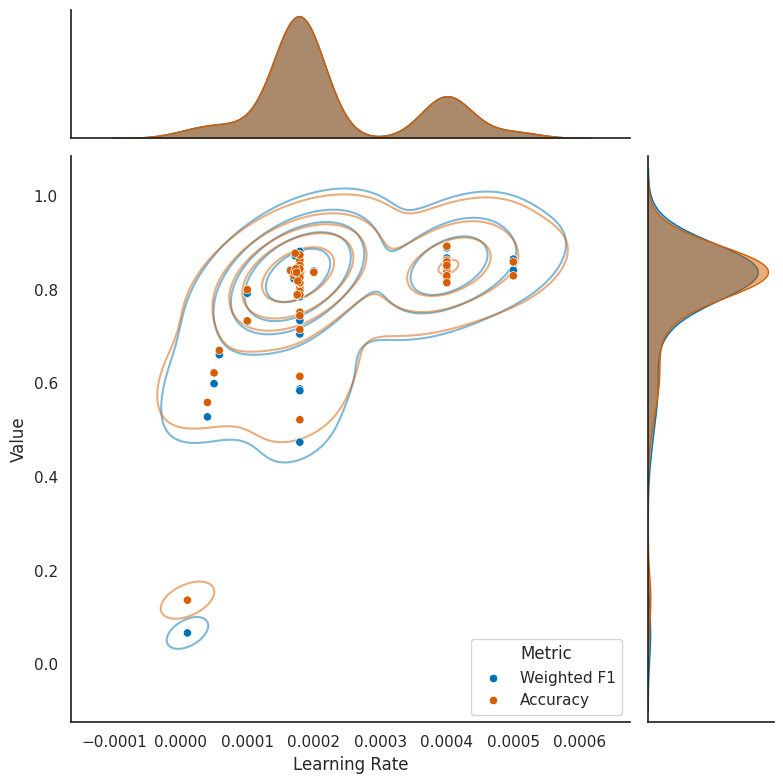

In [276]:
make_graph(f1_tuning, x='Learning Rate', name="LR")

## Hidden Size per Folds

    Hidden Size        F1  Accuracy
10        100.0  0.881710  0.874074
22        100.0  0.661093  0.670370
34        100.0  0.839489  0.837037
46        100.0  0.823380  0.829630
58        100.0  0.842551  0.840741


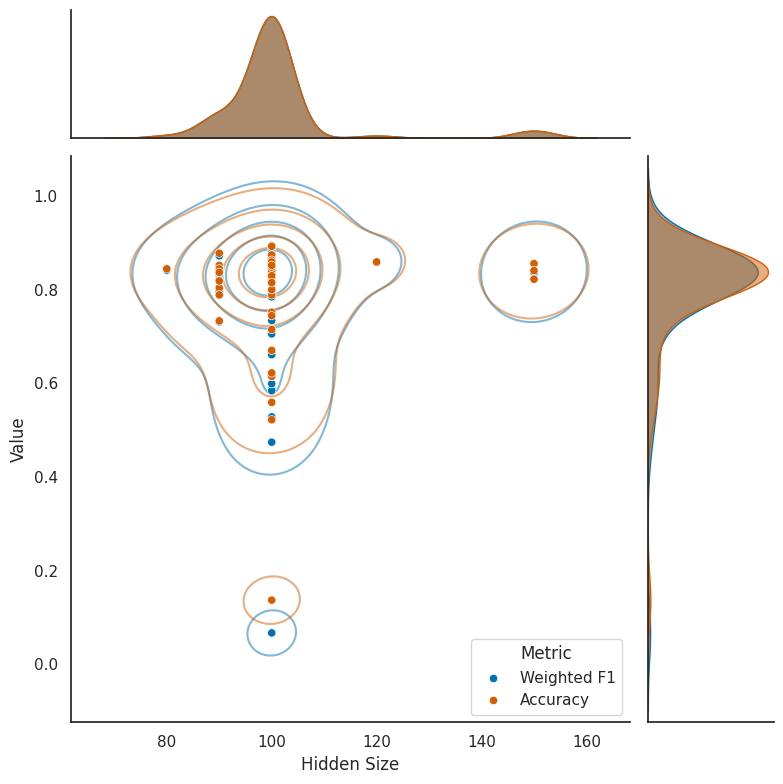

In [277]:
hidden_size_data = metrics_vs_hidden_size()
print(hidden_size_data.head(5))
make_graph(hidden_size_data, x='Hidden Size', name="HS")
#sns.jointplot(x='Hidden Size', y='F1', data=hidden_size_data, kind="hex", color="#4CB391")
#sns.jointplot(x='Hidden Size', y='Accuracy', data=hidden_size_data, kind="hex", color="#4CB391")

## Epochs per Folds

    Hidden Size        F1  Accuracy
10        100.0  0.881710  0.874074
22        100.0  0.661093  0.670370
34        100.0  0.839489  0.837037
46        100.0  0.823380  0.829630
58        100.0  0.842551  0.840741


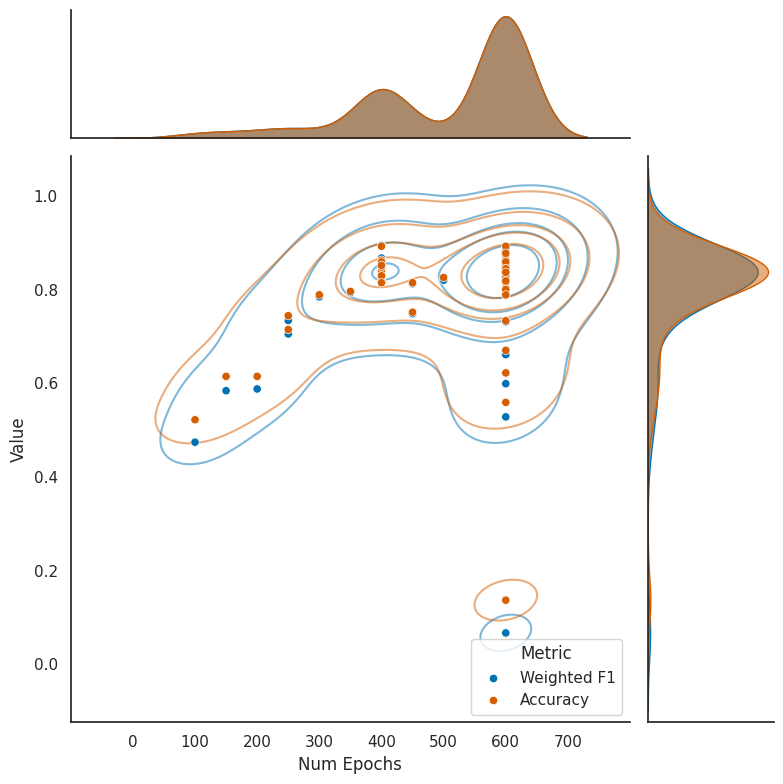

In [278]:
epoch_data = metrics_vs_epochs()
print(hidden_size_data.head(5))
make_graph(epoch_data, x='Num Epochs', name="EP")
#sns.jointplot(x='Num Epochs', y='F1', data=epoch_data, kind="hex", color="#4CB391")
#sns.jointplot(x='Num Epochs', y='Accuracy', data=epoch_data, kind="hex", color="#4CB391")

In [279]:
#g = sns.jointplot(data=epoch_data, x="Num Epochs", y="F1")
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

## Batch Size per Folds

    Batch Size        F1  Accuracy
10        32.0  0.881710  0.874074
22        32.0  0.661093  0.670370
34        32.0  0.839489  0.837037
46        32.0  0.823380  0.829630
58        32.0  0.842551  0.840741


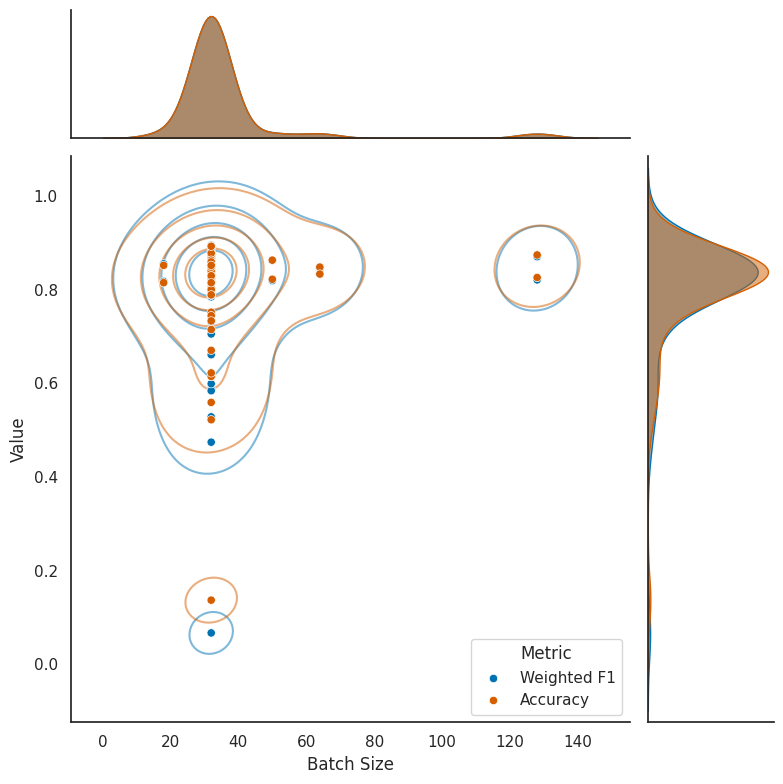

In [280]:
batch_data = metrics_vs_batch_size()
print(batch_data.head(5))
make_graph(batch_data, x='Batch Size', name="BS")
#sns.jointplot(x='Batch Size', y='F1', data=batch_data, kind="hex", color="#4CB391")
#sns.jointplot(x='Batch Size', y='Accuracy', data=batch_data, kind="hex", color="#4CB391")